# Compressed Sensing MR - CNN Training

In this notebook we are going to train a CNN to perform compressed sensing. In this illustration we extract patches using the [Calgary-Campinas-347](http://miclab.fee.unicamp.br/tools) public dataset. 

The goal of this tutorial is:
 - Illustrate how to to train a CNN for compressed sensing.
 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import nibabel as nib
import os
import glob
import sys
import random
import time

from keras.callbacks import ModelCheckpoint, EarlyStopping

MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cnn_utils

Using TensorFlow backend.


In [2]:
patches_path = "/media/roberto/DATA/CS-CC347"
max_value = 1000.0
#Loading data
data = np.load(os.path.join(patches_path,"cs_cc347_orig.npy")).astype(float)/max_value
data_under = np.load(os.path.join(patches_path,"cs_cc347_under.npy")).astype(float)/max_value

# Splitting into development and test set
n = int(data.shape[0]*0.3)
data_train = data[:-n]
data_test = data[-n:]
data_train_under = data_under[:-n]
data_test_under = data_under[-n:]

#Shuffling samples
indexes = np.arange(0,data_train.shape[0],dtype = int)
np.random.shuffle(indexes)
data_train = data_train[indexes]
data_train_under = data_train_under[indexes]

In [3]:
print data_train.shape
print data_test.shape
# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='mean_absolute_error',
                                        patience=5, 
                                        verbose=1, mode='min')
# Checkpoint callback to save model after each improvement along the epochs
checkpoint = ModelCheckpoint('cnn_cs_2x_best.hdf5', mode = 'min', monitor='mean_absolute_error'
                            ,verbose=0, save_best_only=True, save_weights_only = True)

model = cnn_utils.get_unet_mod_reg((256,256),nchannels = 1,\
                                   learning_rate = 1e-3,\
                                   learning_decay =1e-6)   
model.load_weights('cnn_cs_2x_best.hdf5')
print model.summary()

(4858, 256, 256)
(2082, 256, 256)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise) (None, 256, 256, 1)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 32)  320         gaussian_noise_1[0][0]           
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 32)  9248        conv2d_1[0][0]                   
_________________________________________________________

In [4]:
hist = model.fit(data_train_under[:,:,:,np.newaxis],data_train[:,:,:,np.newaxis],epochs=80,
                 batch_size=16,
                 verbose=1,
                 validation_split=0.3,callbacks=[checkpoint,earlyStopping])       

Train on 3400 samples, validate on 1458 samples
Epoch 1/80
3400/3400 [==============================] - 147s - loss: 0.0148 - mean_absolute_error: 0.0148 - val_loss: 0.0126 - val_mean_absolute_error: 0.0126
Epoch 2/80
3400/3400 [==============================] - 141s - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss: 0.0123 - val_mean_absolute_error: 0.0123
Epoch 3/80
3400/3400 [==============================] - 142s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0118 - val_mean_absolute_error: 0.0118
Epoch 4/80
3400/3400 [==============================] - 143s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0127 - val_mean_absolute_error: 0.0127
Epoch 5/80
3400/3400 [==============================] - 144s - loss: 0.0116 - mean_absolute_error: 0.0116 - val_loss: 0.0112 - val_mean_absolute_error: 0.0112
Epoch 6/80
3400/3400 [==============================] - 146s - loss: 0.0115 - mean_absolute_error: 0.0115 - val_loss: 0.0114 - val_mean_absolute_error: 0.011

3400/3400 [==============================] - 141s - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 52/80
3400/3400 [==============================] - 140s - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 53/80
3400/3400 [==============================] - 141s - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 54/80
3400/3400 [==============================] - 141s - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 55/80
3400/3400 [==============================] - 141s - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 56/80
3400/3400 [==============================] - 142s - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0099 - val_mean_absolute_error: 0.0099
Epoch 57/80
3400/3400 [=============================

In [5]:
np.save(os.path.join(patches_path,"cs_cc347_train.npy"),(data_train*1000).astype(np.uint16))
np.save(os.path.join(patches_path,"cs_cc347_train_under.npy"),(data_train_under*1000).astype(np.uint16))
np.save(os.path.join(patches_path,"cs_cc347_test.npy"),(data_test*1000).astype(np.uint16))
np.save(os.path.join(patches_path,"cs_cc347_test.npy"),(data_test_under*1000).astype(np.uint16))

In [6]:
model = cnn_utils.get_unet_mod_reg((256,256),nchannels = 1,\
                                   learning_rate = 1e-3,\
                                   learning_decay =5e-6)   
model.load_weights('cnn_cs_2x_best.hdf5')
predict = model.predict(data_test_under[:,:,:,np.newaxis])[:,:,:,0]
error = np.abs(predict-data_test).mean()
print error
print data_test.mean()

0.0121091901165
0.0878469851491


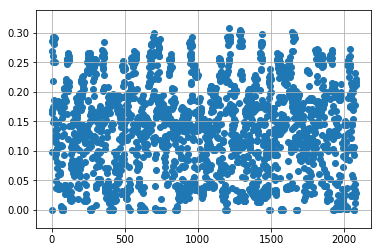

In [7]:
plt.figure()
plt.scatter(np.arange(data_test.shape[0]),np.abs(predict-data_test).mean(axis = (1,2))/data_test.mean())
plt.grid()
plt.show()

400


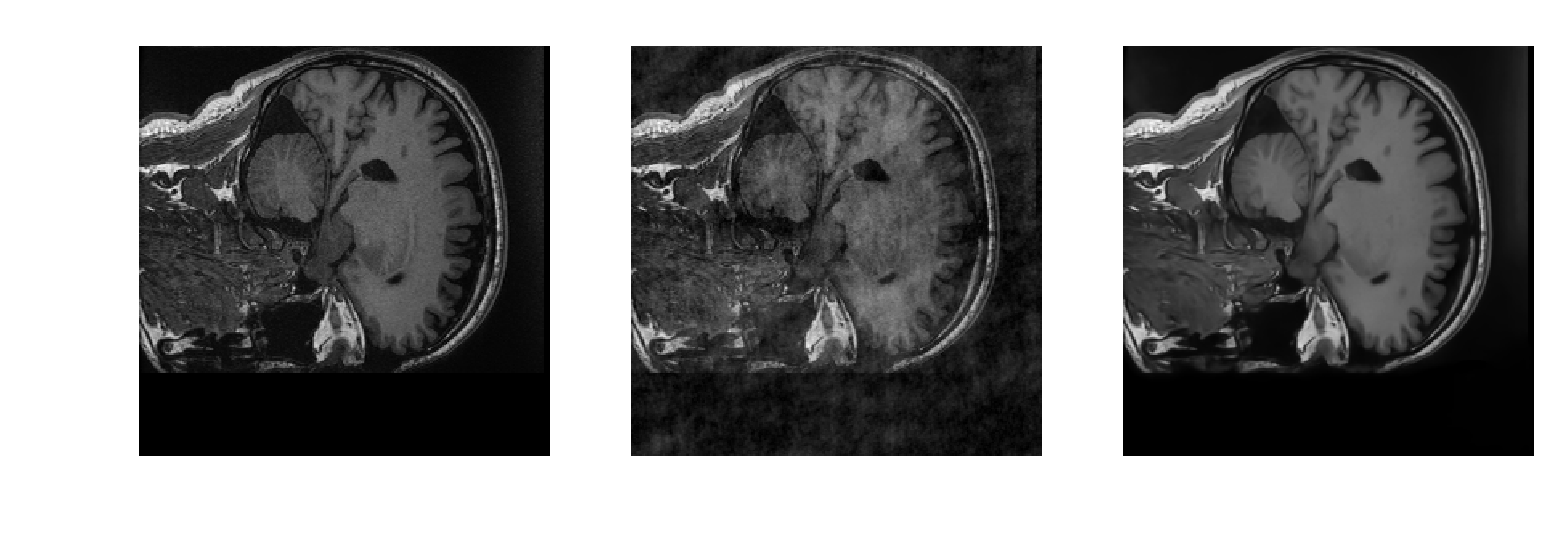

In [9]:
nb = 400
print nb
plt.figure(dpi = 300)
plt.subplot(131)
plt.imshow(data_test[nb],cmap = 'gray')
plt.axis("off")
plt.subplot(132)
plt.imshow(data_test_under[nb],cmap = 'gray')
plt.axis("off")
plt.subplot(133)
plt.imshow(predict[nb],cmap = 'gray')
plt.axis("off")
plt.show()